# Imports

In [1]:
import os

os.chdir('/home/roberto/Github/De-Filippo-et-al-2022')

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dill
import numpy as np
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from rich import print
from tqdm.notebook import tqdm
from time import perf_counter
from operator import itemgetter
from scipy.stats import zscore
from Utils.Settings import window_spike_hist, output_folder_calculations, neuropixel_dataset, var_thr, minimum_ripples_count_spike_analysis, minimum_ripples_count_generated_in_lateral_or_medial_spike_analysis
from Utils.Utils import acronym_to_main_area, clean_ripples_calculations, find_ripples_clusters_new, \
    batch_process_spike_hists_by_seed_location, process_spike_hists
import matplotlib.pyplot as plt
from multiprocessing import Pool, Manager
import seaborn as sns
import pingouin as pg
from Utils.Utils import color_to_labels, color_to_labels_custom_palette
from Utils.Style import palette_ML
from Utils.Utils import acronym_color_map
from statannotations.Annotator import Annotator

/alzheimer/Roberto/Software/mambaforge/envs/De-Filippo-et-al-2022/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/alzheimer/Roberto/Software/mambaforge/envs/De-Filippo-et-al-2022/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
pd.set_option('display.max_rows',40)
pd.set_option('display.max_columns', None)

# Process

In [4]:
t1_start = perf_counter()

manifest_path = f"{neuropixel_dataset}/manifest.json"

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()
#ProfileReport(sessions)

with open(f"{output_folder_calculations}/clean_ripples_calculations.pkl", 'rb') as f:
    ripples_calcs = dill.load(f)


spike_hists = {}

input_rip = []
for session_id in ripples_calcs.keys():
    ripples = ripples_calcs[session_id][3].copy()
    ripples = ripples.groupby('Probe number-area').filter(lambda group: group['∫Ripple'].var() > var_thr)
    input_rip.append(ripples.groupby('Probe number-area').mean()['L-R (µm)'])

lr_space = pd.concat(input_rip)

medial_lim = lr_space.quantile(.33333)
lateral_lim = lr_space.quantile(.666666)
center = lr_space.median()
medial_lim_lm = medial_lim - 5691.510009765625
lateral_lim_lm = lateral_lim - 5691.510009765625

def l_m_classifier(row):
    if row['Source M-L (µm)'] < medial_lim_lm:
        v = 'Medial'
    elif row['Source M-L (µm)'] > lateral_lim_lm:
        v = 'Lateral'
    else:
        v = 'Central'
    return v

In [5]:
session_id = list(ripples_calcs.keys())[1]
session_id

719161530

In [6]:

session = cache.get_session_data(session_id)  # , amplitude_cutoff_maximum = np.inf, presence_ratio_minimum = -np.inf, isi_violations_maximum = np.inf)

units = session.units
units['parent area'] = units['ecephys_structure_acronym'].apply(lambda area: acronym_to_main_area(area))


# #  each area, change output name accordingly
areas = np.delete(units['parent area'].unique(),
                  np.argwhere(units['parent area'].unique() == 'grey'))  # delete grey if present


print(f"In session {session_id} areas recorded: {areas}")

spike_times = session.spike_times

ripples = ripples_calcs[session_id][3].copy()

sel_probe = ripples_calcs[session_id][5]

In session 719161530 areas recorded: ['MB' 'HPF' 'Isocortex' 'TH' 'VS']

In [7]:
target_area = "HPF"

In [8]:
space_sub_spike_times = dict(zip(units[units["parent area"] == target_area].index,
                                                 itemgetter(*units[units["parent area"] == target_area].index)(
                                                     spike_times)))

In [9]:
space_sub_spike_times

{950918168: array([6.29355804e+00, 7.48255933e+00, 8.65639394e+00, ...,
        9.66544865e+03, 9.66545212e+03, 9.66546562e+03]),
 950918182: array([7.19351989e-01, 7.36285341e-01, 1.21838586e+00, ...,
        9.66543868e+03, 9.66544935e+03, 9.66546632e+03]),
 950918424: array([9.81952275e-01, 1.00638563e+00, 1.57468625e+00, ...,
        9.66533248e+03, 9.66540718e+03, 9.66555342e+03]),
 950918517: array([1.99638671e+00, 4.39922265e+00, 7.74792629e+00, ...,
        9.65624151e+03, 9.65762094e+03, 9.66061908e+03]),
 950918505: array([  10.19752895,   20.80674047,   21.17500754, ..., 9575.28195044,
        9631.66347834, 9650.02263162]),
 950918539: array([6.70151936e-01, 7.78918721e-01, 7.87385397e-01, ...,
        9.66515938e+03, 9.66535658e+03, 9.66544938e+03]),
 950918527: array([8.71985489e-01, 8.83518834e-01, 8.97818850e-01, ...,
        9.66502035e+03, 9.66504771e+03, 9.66515191e+03]),
 950918574: array([  65.30112213,  110.07250409,  110.37290441, ..., 9665.15414805,
        9665

In [104]:
def process(session_id, spikes_summary):
    print(session_id)

    session = cache.get_session_data(session_id)  # , amplitude_cutoff_maximum = np.inf, presence_ratio_minimum = -np.inf, isi_violations_maximum = np.inf)

    units = session.units
    units['parent area'] = units['ecephys_structure_acronym'].apply(lambda area: acronym_to_main_area(area))


    # #  each area, change output name accordingly
    areas = np.delete(units['parent area'].unique(),
                      np.argwhere(units['parent area'].unique() == 'grey'))  # delete grey if present

    if 'HPF' in areas:
        areas = ['HPF']
    else:
        return

    print(f"In session {session_id} areas recorded: {areas}")

    spike_times = session.spike_times

    ripples = ripples_calcs[session_id][3].copy()

    sel_probe = ripples_calcs[session_id][5]

    print(f"number ripples on best probe: {ripples[ripples['Probe number'] == sel_probe].shape[0]}")

    if ripples[ripples['Probe number'] == sel_probe].shape[0] < minimum_ripples_count_spike_analysis:
        return

    ripples = ripples.groupby('Probe number-area').filter(lambda group: group['∫Ripple'].var() > var_thr)

    ripples = ripples.sort_values(by='Start (s)').reset_index(drop=True)
    ripples = ripples[ripples['Area'] == 'CA1']
    ripples = ripples.reset_index().rename(columns={'index': 'Ripple number'})

    print(session_id, 'Recording in each ML section:',
          np.any(ripples['L-R (µm)'].unique() < medial_lim) & np.any(ripples['L-R (µm)'].unique() > lateral_lim) & \
          np.any((ripples['L-R (µm)'].unique() > medial_lim) & (ripples['L-R (µm)'].unique() < lateral_lim)))

    ripples['Local strong'] = ripples.groupby('Probe number').apply(
        lambda x: x['∫Ripple'] > x['∫Ripple'].quantile(.9)).sort_index(level=1).values

    try:
        ripples['Z-scored ∫Ripple'] = ripples.groupby('Probe number-area').apply(
            lambda group: zscore(group['∫Ripple'], ddof=1)).droplevel(0)
    except:
        ripples['Z-scored ∫Ripple'] = ripples.groupby('Probe number-area').apply(
            lambda group: zscore(group['∫Ripple'], ddof=1)).T

    to_loop = []
    to_loop.append((ripples.groupby('Probe number-area').mean()['L-R (µm)'].sub(center).abs().idxmin(), 'central'))

    print(f"In session {session_id} process:{to_loop}")
    if ripples.shape[0] > 0:
        for source_area, type_source in to_loop:

            real_ripple_summary = find_ripples_clusters_new(ripples, source_area)
            real_ripple_summary = real_ripple_summary[real_ripple_summary['Spatial engagement']>.5]
            real_ripple_summary['Location seed'] = real_ripple_summary.apply(l_m_classifier, axis=1)

    field_to_use_to_compare = 'parent area'
    target_area = 'HPF'

    #space_sub_spike_times = dict(zip(units[units[field_to_use_to_compare] == target_area].index,
     #                                itemgetter(*units[units[field_to_use_to_compare] == target_area].index)(
     #                                    spike_times)))
    space_sub_spike_times = dict(zip(units.index,
                                     itemgetter(*units.index)(
                                         spike_times)))
    
    window = [.12, .12]
    spikes_per_ripple = {}
    for cluster_id, spikes in tqdm(space_sub_spike_times.items()):
        _ = []
        ripple_start = []
        for index, row in real_ripple_summary.iterrows():
            time_center = row['Start (s)'] + row[row.index.str.contains('lag')].min()# either sum zero or sum a negative value
            _.append(spikes[(spikes > time_center - window[0]) & (spikes < time_center + window[1])]-time_center)
            ripple_start.append(time_center)
        spikes_per_ripple[cluster_id] = (_, ripple_start) 

    _ = [(key, np.concatenate(spikes_per_ripple[key][0]), len(spikes_per_ripple[key][0])) for key in spikes_per_ripple.keys()]

    ripple_firing_rate_0_120 = []
    ripple_firing_rate_0_50 = []
    ripple_firing_rate_50_120 = []
    ripple_firing_rate_120_0 = []
    ripple_firing_rate_20_0 = []
    ripple_firing_rate_50_0 = []
    ripple_firing_rate_120_20 = []
    for key, q, num_ripples in _:
        ripple_firing_rate_0_120.append((key, ((len(q[q>0])/num_ripples)/12)))
        ripple_firing_rate_0_50.append((key, ((len(q[(q>0) & (q<.05)])/num_ripples)/5)))
        ripple_firing_rate_50_120.append((key, ((len(q[q>.05])/num_ripples)/7)))
        ripple_firing_rate_120_0.append((key, ((len(q[(q>-.12) & (q<0)])/num_ripples)/12)))
        ripple_firing_rate_20_0.append((key, ((len(q[(q>-.02) & (q<0)])/num_ripples)/2)))
        ripple_firing_rate_50_0.append((key, ((len(q[(q>-.05) & (q<0)])/num_ripples)/5)))
        ripple_firing_rate_120_20.append((key, ((len(q[(q>-.12) & (q<-.02)])/num_ripples)/10)))


    mod_df = pd.concat([pd.DataFrame(ripple_firing_rate_0_120, columns=['unit_id', 'Firing rate (0-120 ms)']), 
                        pd.DataFrame(ripple_firing_rate_0_50, columns=['unit_id', 'Firing rate (0-50 ms)'])['Firing rate (0-50 ms)'],
                        pd.DataFrame(ripple_firing_rate_50_120, columns=['unit_id', 'Firing rate (50-120 ms)'])['Firing rate (50-120 ms)'],
                       pd.DataFrame(ripple_firing_rate_120_0, columns=['unit_id', 'Firing rate (120-0 ms)'])['Firing rate (120-0 ms)'],
                       pd.DataFrame(ripple_firing_rate_20_0, columns=['unit_id', 'Firing rate (20-0 ms)'])['Firing rate (20-0 ms)'],
                       pd.DataFrame(ripple_firing_rate_50_0, columns=['unit_id', 'Firing rate (50-0 ms)'])['Firing rate (50-0 ms)'],
                         pd.DataFrame(ripple_firing_rate_120_20, columns=['unit_id', 'Firing rate (120-20 ms)'])['Firing rate (120-20 ms)']],
                       axis=1).set_index('unit_id')
    out = pd.concat([units, mod_df], axis=1)#.groupby('ecephys_structure_acronym')[['modulation lat', 'modulation med']].mean()
    out['Session id'] = session_id
    spikes_summary[session_id] = out
    
    return spikes_summary

In [ ]:
%%time 

manager = Manager()

spikes_summary = manager.dict()
input_multiprocessing = []
for ecephys_session_id in  list(ripples_calcs.keys())[::-1]:
        input_multiprocessing.append((ecephys_session_id, spikes_summary)) 

pool = Pool(processes=15) # Instantiate the pool here

pool.starmap_async(process, [x for x in input_multiprocessing])
pool.close()
pool.join()
print(len(spikes_summary))

In [106]:
spikes_summary = dict(spikes_summary)

In [107]:
with open(f"{output_folder_calculations}/units_summary_with_added_metrics_anti_swr.pkl", 'wb') as f:
    dill.dump(spikes_summary, f)


# Load data

In [10]:
with open(f"{output_folder_calculations}/units_summary_with_added_metrics_anti_swr.pkl", 'rb') as f:
    spikes_summary = dill.load(f)

In [11]:

all_areas_recorded = [item for sublist in  sessions['ecephys_structure_acronyms'].to_list() for item in sublist]

count_areas_recorded = pd.Series(all_areas_recorded).value_counts()

In [139]:
summary_units_df = pd.concat(spikes_summary.values())

neurons_per_area = summary_units_df.groupby('ecephys_structure_acronym').size()

summary_units_df['Ripple modulation (0-50 ms)'] = (summary_units_df['Firing rate (0-50 ms)'] - summary_units_df['Firing rate (120-0 ms)'] )/ \
                                                            ( summary_units_df['Firing rate (120-0 ms)'])

summary_units_df['Ripple modulation (50-120 ms)'] = (summary_units_df['Firing rate (50-120 ms)']- summary_units_df['Firing rate (120-0 ms)']) / \
                                                               ( summary_units_df['Firing rate (120-0 ms)'])

summary_units_df['Ripple modulation (0-120 ms)'] = (summary_units_df['Firing rate (0-120 ms)'] - summary_units_df['Firing rate (120-0 ms)'])/ \
                                                            (summary_units_df['Firing rate (120-0 ms)'] )


summary_units_df['Pre-ripple modulation'] = (summary_units_df['Firing rate (20-0 ms)'] - summary_units_df['Firing rate (120-20 ms)'] ) / \
                                                (summary_units_df['Firing rate (120-20 ms)'] )



summary_units_df_sub = summary_units_df[(summary_units_df['ecephys_structure_acronym'].isin(count_areas_recorded[count_areas_recorded>8].index))&
                                        (summary_units_df['ecephys_structure_acronym'].isin(neurons_per_area[neurons_per_area>100].index))&
                                       (summary_units_df['ecephys_structure_acronym']!='grey')&
                                       (summary_units_df['ecephys_structure_acronym']!='HPF')]

summary_units_df_sub = summary_units_df_sub[~(summary_units_df_sub['Ripple modulation (0-50 ms)'].isin([np.nan, np.inf, -np.inf])) & 
                        ~(summary_units_df_sub['Ripple modulation (50-120 ms)'].isin([np.nan, np.inf, -np.inf])) & 
                        ~(summary_units_df_sub['Ripple modulation (0-120 ms)'].isin([np.nan, np.inf, -np.inf])) & 
                        ~(summary_units_df_sub['Pre-ripple modulation'].isin([np.nan, np.inf, -np.inf]))]


summary_units_df_sub.columns = summary_units_df_sub.columns.str.replace('_', ' ')
summary_units_df_sub.columns = summary_units_df_sub.columns.str.capitalize()

summary_units_df_sub = summary_units_df_sub.rename(columns={"Left right ccf coordinate":"L-R", "Anterior posterior ccf coordinate":"A-P", "Dorsal ventral ccf coordinate":"D-V"})
summary_units_df_sub = summary_units_df_sub.rename(columns={"Ecephys structure acronym":"Brain region", "Parent area":"Parent brain region"})

summary_units_df_sub["M-L"] = summary_units_df_sub["L-R"] - 5691.510009765625

subset_clusters = summary_units_df_sub[summary_units_df_sub['Firing rate (120-20 ms)']>0.025]#per 10 ms

waveform_treshold = 0.4
# add a new column "type neuron" using apply() method
subset_clusters["Type neuron"] = subset_clusters["Waveform duration"].apply(lambda x: "Putative inh" if x <= 0.4 else "Putative exc")

# add a new column "Anti-SWR"
subset_clusters["Anti-SWR"] = subset_clusters["Ripple modulation (0-50 ms)"] < -0.5


/alzheimer/Roberto/Software/mambaforge/envs/De-Filippo-et-al-2022/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/alzheimer/Roberto/Software/mambaforge/envs/De-Filippo-et-al-2022/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [140]:
with open(f"{output_folder_calculations}/subset_clusters.pkl", 'wb') as f:
    dill.dump(subset_clusters, f)


In [94]:
anti_SWR_counts = pd.Series(subset_clusters.groupby(["Session id", "Parent brain region"])\
.apply(lambda x: x[x['Ripple modulation (0-50 ms)']<-.5].shape[0]/x.shape[0]), name="Probability anti-SWR")

anti_SWR_counts = pd.DataFrame(anti_SWR_counts).reset_index()

In [95]:
with open(f"{output_folder_calculations}/anti_SWR_counts.pkl", 'wb') as f:
    dill.dump(anti_SWR_counts, f)


In [134]:
palette_parent_areas = dict()
for area in subset_clusters['Parent brain region'].unique():
    palette_parent_areas[area] = '#' + ''.join(f'{i:02X}' for i in acronym_color_map[area]);

palette_areas = dict()
for area in subset_clusters['Brain region'].unique():
    palette_areas[area] = '#' + ''.join(f'{i:02X}' for i in acronym_color_map[area]);

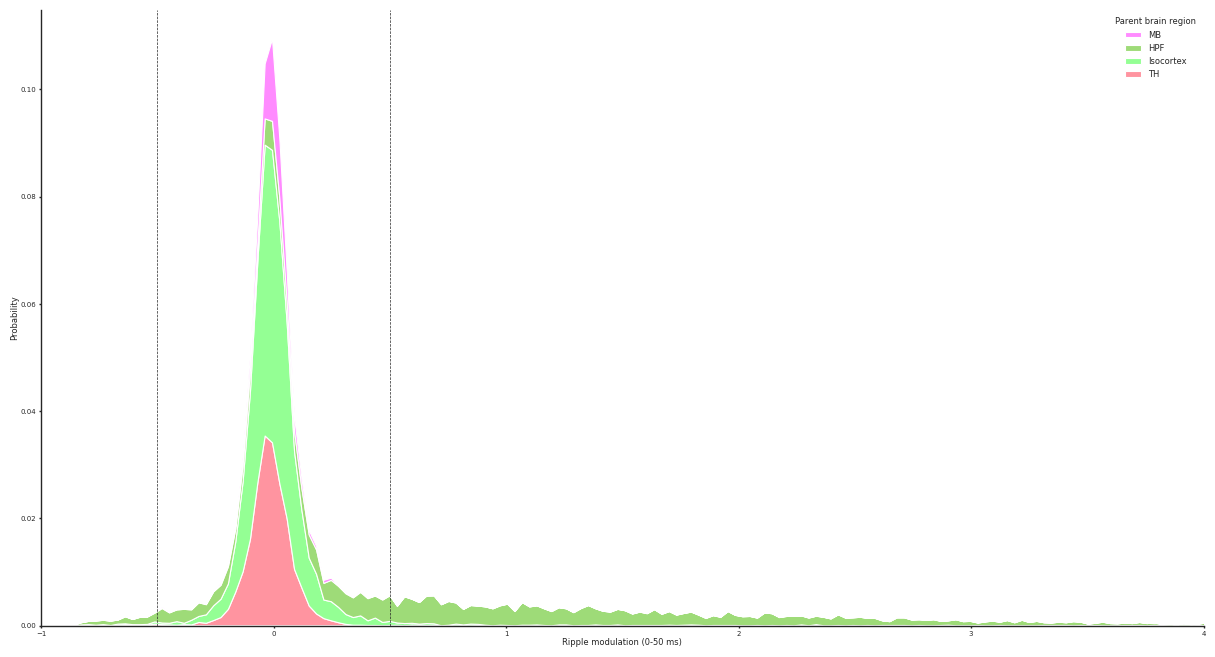

In [93]:
fig, axs = plt.subplots( 1 ,figsize=(15,8))

sns.histplot(data=subset_clusters, x='Ripple modulation (0-50 ms)',
                hue='Parent brain region', palette=palette_parent_areas, ax=axs, multiple="stack", element="poly", stat="probability")
axs.set_xlim((-1,4))
axs.axvline(-.5, color=".15", linestyle="--")
axs.axvline(.5, color=".15", linestyle="--")


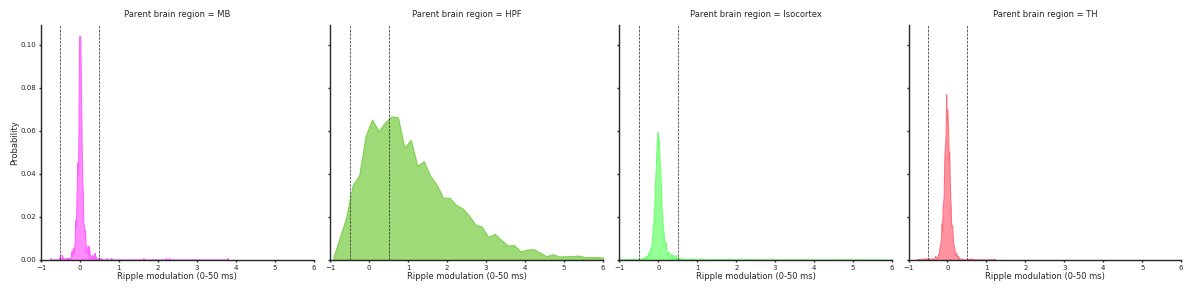

In [16]:
g = sns.FacetGrid(subset_clusters, col="Parent brain region", hue="Parent brain region", palette=palette_parent_areas)
g.map(sns.histplot, "Ripple modulation (0-50 ms)", element="poly", stat="probability")
g.set(xlim=(-1, 6))

# flatten axes into a 1-d array
axes = g.axes.flatten()

# iterate through the axes
for ax in axes:
    ax.axvline(.5, color=".15", linestyle="--")
    ax.axvline(-.5, color=".15", linestyle="--")

In [17]:
anti_SWR_counts = pd.Series(subset_clusters.groupby(["Session id", "Parent brain region"])\
.apply(lambda x: x[x['Ripple modulation (0-50 ms)']<-.5].shape[0]/x.shape[0]), name="Probability anti-SWR")

anti_SWR_counts = pd.DataFrame(anti_SWR_counts).reset_index()

<AxesSubplot:xlabel='Parent brain region', ylabel='Probability anti-SWR'>

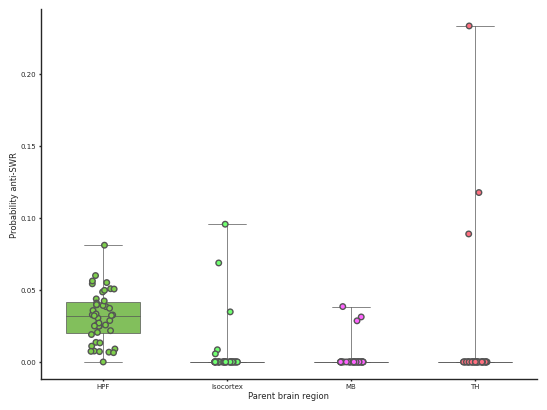

In [20]:
sns.stripplot(data=anti_SWR_counts, y="Probability anti-SWR", x="Parent brain region", size=4, color=".3", linewidth=1, palette=palette_parent_areas)
sns.boxplot(data=anti_SWR_counts, y="Probability anti-SWR", x="Parent brain region",  whis=[0, 100], width=.6, palette=palette_parent_areas)

In [21]:
anti_SWR_counts_brain_regions = pd.Series(subset_clusters[subset_clusters["Parent brain region"]=="HPF"].groupby(["Session id", "Brain region"])\
.apply(lambda x: x[x['Ripple modulation (0-50 ms)']<-.5].shape[0]/x.shape[0]), name="Probability anti-SWR")
anti_SWR_counts_brain_regions = pd.DataFrame(anti_SWR_counts_brain_regions).reset_index()

Text(0.5, 1.0, 'Number anti-SWR neurons per session')

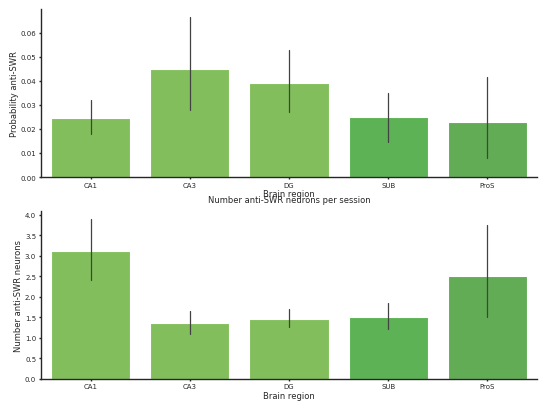

In [148]:
fig, axs = plt.subplots(2)
sns.barplot(data=anti_SWR_counts_brain_regions, y="Probability anti-SWR", x="Brain region", palette=palette_areas, ax=axs[0])
sns.barplot(data=pd.Series(subset_clusters[(subset_clusters["Parent brain region"]=="HPF")&(subset_clusters["Anti-SWR"]==True)].groupby(["Session id", "Brain region"]).size(), name="Number anti-SWR neurons").reset_index(), 
            y="Number anti-SWR neurons", x="Brain region", palette=palette_areas, ax=axs[1])
axs[1].set_title("Number anti-SWR neurons per session")

In [117]:
palette_type_neuron={"Putative exc": "#D64933", "Putative inh": "#00C2D1"}
palette_anti_SWR={True: "#A268E4", False: "#454545"}

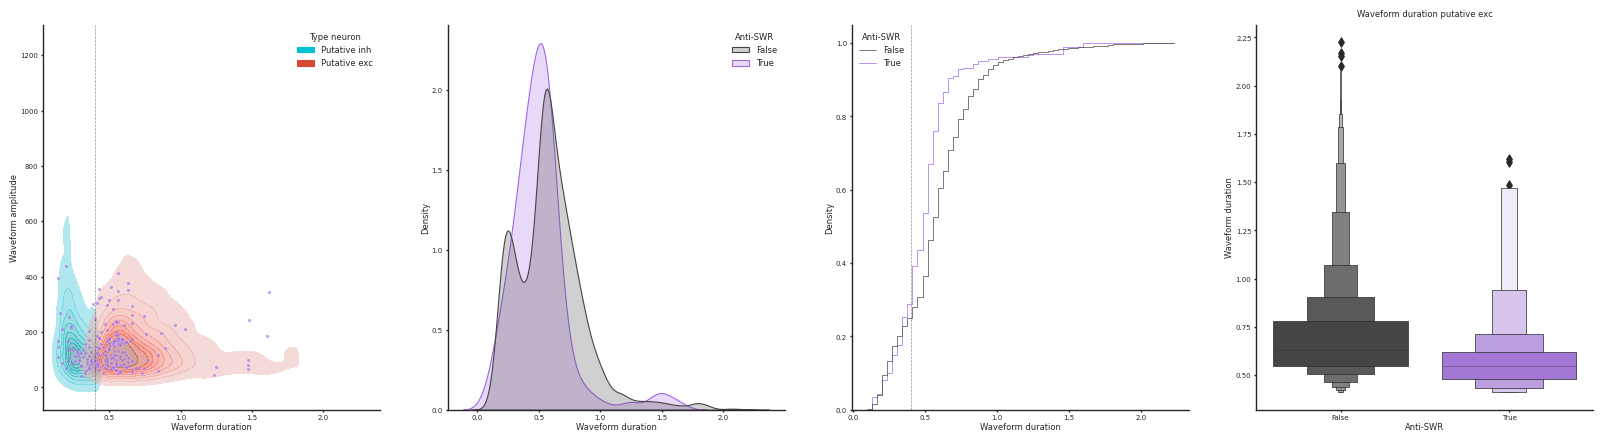

In [142]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))
sns.kdeplot(palette=palette_anti_SWR, data=subset_clusters[(subset_clusters["Parent brain region"]=="HPF")], x="Waveform duration", hue="Anti-SWR", fill=True, common_norm=False, ax=axs[1])
sns.histplot(palette=palette_anti_SWR,  data=subset_clusters[(subset_clusters["Parent brain region"]=="HPF")], x="Waveform duration",  ax=axs[2], hue="Anti-SWR", cumulative=True, 
             element="step", fill=False, stat="density", common_norm=False)
axs[2].axvline(.4, linestyle="--", alpha=.5, color=".15")
sns.boxenplot(palette=palette_anti_SWR, data=subset_clusters[(subset_clusters["Parent brain region"]=="HPF")&(subset_clusters["Waveform duration"]>=0.4)], y="Waveform duration", x="Anti-SWR", ax= axs[3])
axs[3].set_title("Waveform duration putative exc")

y = "Waveform amplitude"
sns.kdeplot(ax= axs[0], data=subset_clusters[(subset_clusters["Parent brain region"]=="HPF")], x="Waveform duration", hue="Type neuron", y=y, palette=palette_type_neuron, fill=True, alpha=.5)
sns.scatterplot(color=palette_anti_SWR[True], ax= axs[0], data=subset_clusters[((subset_clusters["Parent brain region"]=="HPF"))&(subset_clusters["Anti-SWR"]==True)], x="Waveform duration", y=y, s=6, alpha=.6)
axs[0].axvline(.4, linestyle="--", alpha=.5, color=".15")

# Process waveforms

## Calculate CA1 waveforms

In [37]:
HPF_units = subset_clusters[(subset_clusters["Parent brain region"]=="HPF")]

exc = []
inh = []
exc_anti = []
inh_anti = []

waveform_dur_thr= .4


for session_id in tqdm(HPF_units["Session id"].unique()):
    session = cache.get_session_data(session_id)
    
    sub_units = HPF_units[HPF_units["Session id"]==session_id]
    
    sub_units = sub_units[sub_units["Brain region"]=="CA1"]
    
    inh_units = sub_units[(sub_units["Waveform duration"]<waveform_dur_thr) & (sub_units["Anti-SWR"]==False)]
    exc_units = sub_units[(sub_units["Waveform duration"]>=waveform_dur_thr)& (sub_units["Anti-SWR"]==False)]
    inh_units_anti = sub_units[(sub_units["Waveform duration"]<waveform_dur_thr) & (sub_units["Anti-SWR"]==True)]
    exc_units_anti = sub_units[(sub_units["Waveform duration"]>=waveform_dur_thr)& (sub_units["Anti-SWR"]==True)]
    
    for unit_id in inh_units.index:
        try: 
            peak_channel = session.units.loc[unit_id].peak_channel_id
            wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel).to_numpy()
            inh.append(wv)
        except:
            continue
    for unit_id in exc_units.index:
        try:
            peak_channel = session.units.loc[unit_id].peak_channel_id
            wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel).to_numpy()
            exc.append(wv)
        except:
            continue
    for unit_id in inh_units_anti.index:
        try: 
            peak_channel = session.units.loc[unit_id].peak_channel_id
            wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel).to_numpy()
            inh_anti.append(wv)
        except:
            continue
    for unit_id in exc_units_anti.index:
        try:
            peak_channel = session.units.loc[unit_id].peak_channel_id
            wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel).to_numpy()
            exc_anti.append(wv)
        except:
            continue

  0%|          | 0/44 [00:00<?, ?it/s]

In [38]:
with open(f"{output_folder_calculations}/CA1_waveforms_anti.pkl", "wb") as fp:
    dill.dump([exc, exc_anti, inh, inh_anti, session.mean_waveforms[ 950913000].time.to_numpy()], fp)

## Calculate CA3 waveforms

In [52]:
HPF_units = subset_clusters[(subset_clusters["Parent brain region"]=="HPF")]

exc = []
inh = []
exc_anti = []
inh_anti = []

waveform_dur_thr= .4


for session_id in tqdm(HPF_units["Session id"].unique()):
    session = cache.get_session_data(session_id)
    
    sub_units = HPF_units[HPF_units["Session id"]==session_id]
    
    sub_units = sub_units[sub_units["Brain region"]=="CA3"]
    
    inh_units = sub_units[(sub_units["Waveform duration"]<waveform_dur_thr) & (sub_units["Anti-SWR"]==False)]
    exc_units = sub_units[(sub_units["Waveform duration"]>=waveform_dur_thr)& (sub_units["Anti-SWR"]==False)]
    inh_units_anti = sub_units[(sub_units["Waveform duration"]<waveform_dur_thr) & (sub_units["Anti-SWR"]==True)]
    exc_units_anti = sub_units[(sub_units["Waveform duration"]>=waveform_dur_thr)& (sub_units["Anti-SWR"]==True)]
    
    for unit_id in inh_units.index:
        try: 
            peak_channel = session.units.loc[unit_id].peak_channel_id
            wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel).to_numpy()
            inh.append(wv)
        except:
            continue
    for unit_id in exc_units.index:
        try:
            peak_channel = session.units.loc[unit_id].peak_channel_id
            wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel).to_numpy()
            exc.append(wv)
        except:
            continue
    for unit_id in inh_units_anti.index:
        try: 
            peak_channel = session.units.loc[unit_id].peak_channel_id
            wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel).to_numpy()
            inh_anti.append(wv)
        except:
            continue
    for unit_id in exc_units_anti.index:
        try:
            peak_channel = session.units.loc[unit_id].peak_channel_id
            wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel).to_numpy()
            exc_anti.append(wv)
        except:
            continue

  0%|          | 0/44 [00:00<?, ?it/s]

In [ ]:
with open(f"{output_folder_calculations}/CA3_waveforms_anti.pkl", "wb") as fp:
    dill.dump([exc, exc_anti, inh, inh_anti, session.mean_waveforms[ 950913000].time.to_numpy()], fp)

# Visualize waveforms and rasters

In [39]:
with open(f'{output_folder_calculations}/CA1_waveforms_anti.pkl', 'rb') as f:
    exc, exc_anti, inh, inh_anti, time = dill.load(f)

Text(0.5, 1.0, 'Putative exc CA1')

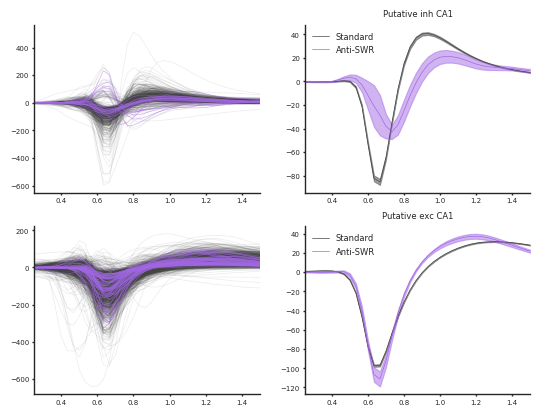

In [132]:
fig, axs = plt.subplots(2,2)
pd.DataFrame(np.vstack(inh), columns=time*1000).T.plot(legend=False, color=palette_anti_SWR[False], alpha=.1, ax=axs[0,0])
pd.DataFrame(np.vstack(inh_anti), columns=time*1000).T.plot(legend=False, color=palette_anti_SWR[True], alpha=.5, ax=axs[0,0])
axs[0,0].set_xlim((0.25,1.5))

x = time*1000
y = pd.DataFrame(np.vstack(inh), columns=time*1000).mean()
error = pd.DataFrame(np.vstack(inh), columns=time*1000).sem() 

axs[0,1].fill_between(x, y-error, y+error, color=palette_anti_SWR[False], alpha=.5)
axs[0,1].plot(x,y, color=palette_anti_SWR[False], label="Standard")

y = pd.DataFrame(np.vstack(inh_anti), columns=time*1000).mean()
error = pd.DataFrame(np.vstack(inh_anti), columns=time*1000).sem() 

axs[0,1].fill_between(x, y-error, y+error, color=palette_anti_SWR[True], alpha=.5)
axs[0,1].plot(x,y, color=palette_anti_SWR[True], label="Anti-SWR")
axs[0,1].set_xlim((0.25,1.5))
axs[0,1].legend()
axs[0,1].set_title("Putative inh CA1")


pd.DataFrame(np.vstack(exc), columns=time*1000).T.plot(legend=False, color=palette_anti_SWR[False], alpha=.1, ax=axs[1,0])
pd.DataFrame(np.vstack(exc_anti), columns=time*1000).T.plot(legend=False, color=palette_anti_SWR[True], alpha=.5, ax=axs[1,0])
axs[1,0].set_xlim((0.25,1.5))

x = time*1000
y = pd.DataFrame(np.vstack(exc), columns=time*1000).mean()
error = pd.DataFrame(np.vstack(exc), columns=time*1000).sem() 

axs[1,1].fill_between(x, y-error, y+error, color=palette_anti_SWR[False], alpha=.5)
axs[1,1].plot(x,y, color=palette_anti_SWR[False], label="Standard")

y = pd.DataFrame(np.vstack(exc_anti), columns=time*1000).mean()
error = pd.DataFrame(np.vstack(exc_anti), columns=time*1000).sem() 

axs[1,1].fill_between(x, y-error, y+error, color=palette_anti_SWR[True], alpha=.5)
axs[1,1].plot(x,y, color=palette_anti_SWR[True], label="Anti-SWR")
axs[1,1].set_xlim((0.25,1.5))
axs[1,1].legend()
axs[1,1].set_title("Putative exc CA1")

In [43]:
HPF_units = subset_clusters[(subset_clusters["Parent brain region"]=="HPF")]

waveform_dur_thr= .4


session_id = HPF_units["Session id"].unique()[3]

sub_units = HPF_units[HPF_units["Session id"]==session_id]

sub_units = sub_units[sub_units["Brain region"]=="CA1"]

print(len(sub_units[sub_units["Anti-SWR"]==True]))

3

# Process rasters

In [ ]:
spikes_per_ripple = {}
for session_id in tqdm(HPF_units["Session id"].unique()):
    
    sub_units = HPF_units[HPF_units["Session id"]==session_id]
    print(len(sub_units[sub_units["Anti-SWR"]==True]))
    if len(sub_units[sub_units["Anti-SWR"]==True]) > 0:

        session = cache.get_session_data(session_id)  # , amplitude_cutoff_maximum = np.inf, presence_ratio_minimum = -np.inf, isi_violations_maximum = np.inf)

        units = session.units
        units['parent area'] = units['ecephys_structure_acronym'].apply(lambda area: acronym_to_main_area(area))

        # #  each area, change output name accordingly
        areas = np.delete(units['parent area'].unique(),
                          np.argwhere(units['parent area'].unique() == 'grey'))  # delete grey if present



        print(f"In session {session_id} areas recorded: {areas}")

        spike_times = session.spike_times

        ripples = ripples_calcs[session_id][3].copy()

        sel_probe = ripples_calcs[session_id][5]

        print(f"number ripples on best probe: {ripples[ripples['Probe number'] == sel_probe].shape[0]}")


        ripples = ripples.groupby('Probe number-area').filter(lambda group: group['∫Ripple'].var() > var_thr)

        ripples = ripples.sort_values(by='Start (s)').reset_index(drop=True)
        ripples = ripples[ripples['Area'] == 'CA1']
        ripples = ripples.reset_index().rename(columns={'index': 'Ripple number'})


        ripples['Local strong'] = ripples.groupby('Probe number').apply(
            lambda x: x['∫Ripple'] > x['∫Ripple'].quantile(.9)).sort_index(level=1).values

        try:
            ripples['Z-scored ∫Ripple'] = ripples.groupby('Probe number-area').apply(
                lambda group: zscore(group['∫Ripple'], ddof=1)).droplevel(0)
        except:
            ripples['Z-scored ∫Ripple'] = ripples.groupby('Probe number-area').apply(
                lambda group: zscore(group['∫Ripple'], ddof=1)).T

        to_loop = []
        to_loop.append((ripples.groupby('Probe number-area').mean()['L-R (µm)'].sub(center).abs().idxmin(), 'central'))

        print(f"In session {session_id} process:{to_loop}")
        if ripples.shape[0] > 0:
            for source_area, type_source in to_loop:

                real_ripple_summary = find_ripples_clusters_new(ripples, source_area)
                real_ripple_summary = real_ripple_summary[real_ripple_summary['Spatial engagement']>.5]
                real_ripple_summary['Location seed'] = real_ripple_summary.apply(l_m_classifier, axis=1)

        field_to_use_to_compare = 'parent area'
        target_area = 'HPF'

        #space_sub_spike_times = dict(zip(units[units[field_to_use_to_compare] == target_area].index,
         #                                itemgetter(*units[units[field_to_use_to_compare] == target_area].index)(
         #                                    spike_times)))
        space_sub_spike_times = dict(zip(sub_units[(sub_units["Anti-SWR"]==True)].index,
                                         itemgetter(*sub_units[(sub_units["Anti-SWR"]==True)].index)(
                                             spike_times)))

        window = [.12, .12]

        for cluster_id, spikes in tqdm(space_sub_spike_times.items()):
            _ = []
            ripple_start = []
            for index, row in real_ripple_summary.iterrows():
                time_center = row['Start (s)'] + row[row.index.str.contains('lag')].min()# either sum zero or sum a negative value
                _.append(spikes[(spikes > time_center - window[0]) & (spikes < time_center + window[1])]-time_center)
                ripple_start.append(time_center)
            spikes_per_ripple[session_id, cluster_id] = (_, ripple_start) 



In [45]:
with open(f"{output_folder_calculations}/anti_swr_spike_times.pkl", 'wb') as f:
    dill.dump(spikes_per_ripple, f)


In [128]:
with open(f'{output_folder_calculations}/anti_swr_spike_times.pkl', 'rb') as f:
    spikes_per_ripple = dill.load(f)

In [129]:
from itertools import cycle
from matplotlib.colors import ListedColormap
# create a ListedColormap from the "Set1" colormap
cmap = ListedColormap(plt.cm.Set2.colors)

# create a cyclic iterator over the colormap
colors = cycle(cmap.colors)

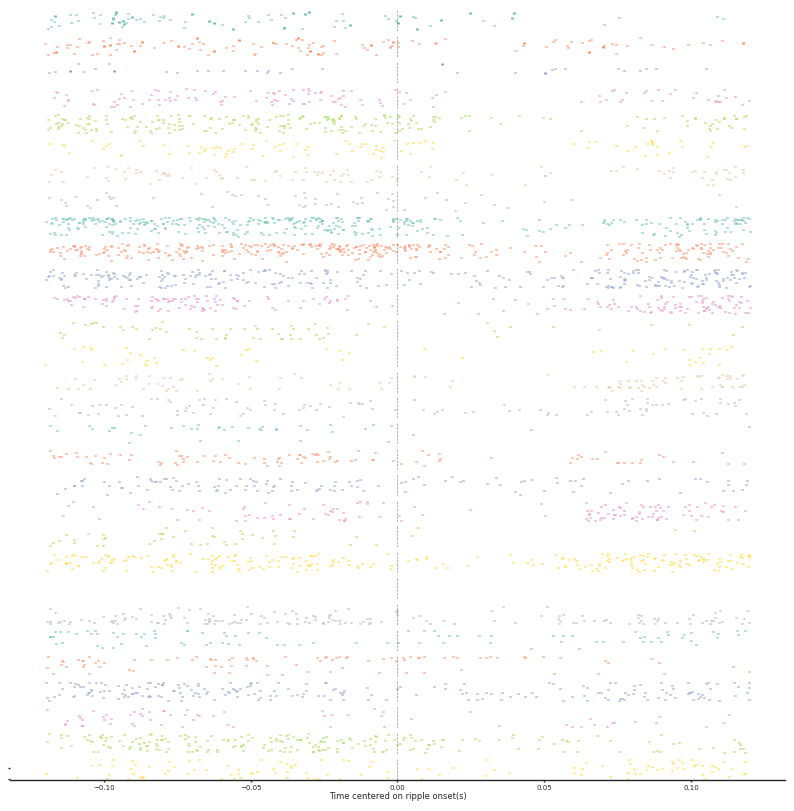

In [130]:
# Create a figure with subplots
n=30
fig, axes = plt.subplots(nrows=len(list(spikes_per_ripple.keys())[:n]), sharex=True, figsize=(10,10))

# Loop through each key in the dictionary
for i, key in enumerate(list(spikes_per_ripple.keys())[:n]):
    # Get the spikes for the current key
    spikes = spikes_per_ripple[key][0]
    
    # Plot the eventplot with the appropriate color and lineoffset
    axes[i].eventplot(spikes, linewidths=2, linelengths=5, color=next(colors))
    axes[i].axvline(0, linestyle="--", alpha=.5, color=".15")
    if i!=n-1:
        axes[i].axis('off')
    else:
        axes[i].set(yticklabels=[])  # remove the tick labels
        axes[i].spines['left'].set_visible(False)
        axes[i].set_xlabel("Time centered on ripple onset(s)")
        
    
# Set the yticks and labels
yticks = np.arange(len(spikes_per_ripple))
